IMPORT LIBRARIES

In [1]:
import numpy as np
import os
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

DIRECTORY PATH

In [2]:
train_dir = '../Data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
val_dir = '../Data/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

In [3]:
i = 0
for dir in os.listdir(train_dir):
    img = nib.load(train_dir + '/' + dir + '/' + dir + '_flair.nii').get_fdata()
    print(img.max())
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    print(img.max())
    break

625.0
1.0


PROCESSING GIEVN TRAIN DATA

In [5]:
i = 0
for dir in os.listdir(train_dir):
    try:
        flair = nib.load(train_dir + '/' + dir + '/' + dir + '_flair.nii').get_fdata()
        # flattenning it,then applying min max scaler and then reforming it into 3D
        flair = scaler.fit_transform(flair.reshape(-1, flair.shape[-1])).reshape(flair.shape)
        
        t1ce = nib.load(train_dir + '/' + dir + '/' + dir + '_t1ce.nii').get_fdata()
        t1ce = scaler.fit_transform(t1ce.reshape(-1, t1ce.shape[-1])).reshape(t1ce.shape)
        
        t2 = nib.load(train_dir + '/' + dir + '/' + dir + '_t2.nii').get_fdata()
        t2 = scaler.fit_transform(t2.reshape(-1, t2.shape[-1])).reshape(t2.shape)
        
        mask = nib.load(train_dir + '/' + dir + '/' + dir + '_seg.nii').get_fdata()
        mask = mask.astype(np.uint8)
        mask[mask==4] = 3
        
        combined = np.stack([flair, t1ce, t2], axis = 3)
        
        combined = combined[56:184, 56:184,13:141]
        mask = mask[56:184, 56:184,13:141]
        
        val, count = np.unique(mask, return_counts=True)
        
        if(1-(count[0]/count.sum())) > 0.01:
            mask = tf.keras.utils.to_categorical(mask, num_classes=4)
            np.save(f"../Data/train/data/{i}.npy", combined)
            np.save(f"../Data/train/mask/{i}.npy", mask)
            i = i + 1
    except Exception as e:
        print(i)

329
343
343


PROCESSING GIVEN TEST DATA

In [11]:
j = 0
for dir in os.listdir(val_dir):
    try:
        flair = nib.load(val_dir + '/' + dir + '/' + dir + '_flair.nii').get_fdata()
        # flattenning it,then applying min max scaler and then reforming it into 3D
        flair = scaler.fit_transform(flair.reshape(-1, flair.shape[-1])).reshape(flair.shape)
        
        t1ce = nib.load(val_dir + '/' + dir + '/' + dir + '_t1ce.nii').get_fdata()
        t1ce = scaler.fit_transform(t1ce.reshape(-1, t1ce.shape[-1])).reshape(t1ce.shape)
        
        t2 = nib.load(val_dir + '/' + dir + '/' + dir + '_t2.nii').get_fdata()
        t2 = scaler.fit_transform(t2.reshape(-1, t2.shape[-1])).reshape(t2.shape)
        
        combined = np.stack([flair, t1ce, t2], axis = 3)
        
        combined = combined[56:184, 56:184,13:141]
        
        np.save(f"../Data/Testing/data/v{j}.npy", combined)
        j = j + 1
    except Exception as e:
        print(j)
        print('----------->' + e)

125


TypeError: can only concatenate str (not "FileNotFoundError") to str


# SPLITING TRAIN DATA INTO TRAIN AND VALIDATION DATA


In [17]:
import shutil
from sklearn.model_selection import train_test_split

In [18]:
# Paths
original_data_dir = '../Data/train/data'
original_mask_dir = '../Data/train/mask'

train_data_dir = '../Data/Split/train/data'
train_mask_dir = '../Data/Split/train/mask'
val_data_dir = '../Data/Split/val/data'
val_mask_dir = '../Data/Split/val/mask'

In [19]:
os.makedirs(train_data_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)
os.makedirs(val_data_dir, exist_ok=True)
os.makedirs(val_mask_dir, exist_ok=True)

In [20]:
# List all data and mask files
data_files = sorted(os.listdir(original_data_dir))
mask_files = sorted(os.listdir(original_mask_dir))

In [23]:
# Ensure that data and mask files correspond
assert len(data_files) == len(mask_files), "The number of data files and mask files should be the same"

In [26]:
data_to_mask = {}
for data_file in data_files:
    # mask_file = data_file.replace('data', 'mask')  # Assuming mask files are named similarly to data files
    if data_file in mask_files:
        data_to_mask[data_file] = data_file
    else:
        raise ValueError(f"No corresponding mask file for {data_file}")

In [29]:
data_keys = list(data_to_mask.keys())
train_data, val_data = train_test_split(data_keys, test_size=0.2, random_state=42)

In [39]:
def move_files(file_list, data_dest, mask_dest, map):
    for file_name in file_list:
        shutil.move(os.path.join(original_data_dir, file_name), os.path.join(data_dest, file_name))
        shutil.move(os.path.join(original_mask_dir, data_to_mask[file_name]), os.path.join(mask_dest, data_to_mask[file_name]))

In [43]:
move_files(train_data, train_data_dir, train_mask_dir, data_to_mask)
move_files(val_data, val_data_dir, val_mask_dir, data_to_mask)

# VISUALIZATION OF IMAGE COMPONENTS AND THEIR CORRESPONDING MASKS

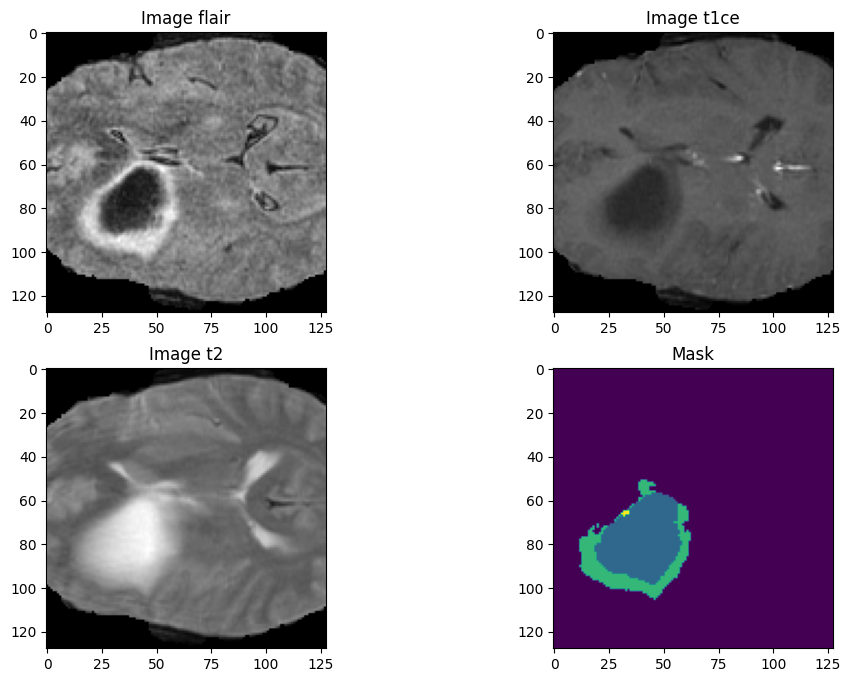

In [8]:
import random

train_img_dir = "../Data/Split/val/data/"
train_mask_dir = "../Data/Split/val/mask/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

Just verifying the shapes of image and mask

In [9]:
train_img_dir = "../Data/Split/val/data/"
train_mask_dir = "../Data/Split/val/mask/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
print(test_img.shape)
test_mask = np.load(train_mask_dir+msk_list[img_num])
print(test_mask.shape)

(128, 128, 128, 3)
(128, 128, 128, 4)
